# Modeling Insurance Portfolio Risk with a Poisson - Zero-Adjusted Gamma model

**Author:** Stefan Pilegaard Pedersen  
**Objective:** Estimate and price aggregate insurance portfolio risk using:
- Fitted severity model (Gamma)
- Stochastic frequency model (Poisson)
- Risk metrics: Expected Loss, VaR, CVaR, Premium


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gamma as gamma_dist, poisson, norm, lognorm
import matplotlib.pyplot as plt
from fitter import Fitter
from IPython.display import Markdown

# Load and clean claims data
df = pd.read_excel('Stefan Pedersen - Case .xlsx', engine='openpyxl')
claims = df['Inf.Adjusted Claim cost'].dropna()
non_zero_claims = claims[claims > 0]  # Gamma requires strictly positive values

## Benchmarking Distribution Fits with Fitter

To identify the most suitable distribution for modeling **claim severity**, we use the `Fitter` package to compare several common continuous distributions:

- Normal
- Lognormal
- Exponential
- Gamma
- Weibull (minimum)

The fitter performs a **nonlinear least squares fitting** of each distribution to the observed claim data and ranks them based on their goodness-of-fit (e.g. using the sum of squared errors or AIC).

The output includes:
- A summary table of fitted parameters for each candidate distribution
- A visual overlay of the fitted probability density functions (PDFs) on the empirical histogram

This analysis helps determine whether the **gamma distribution** (or another) best captures the shape and skewness of the claim distribution


2025-05-21 23:02:01.111 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)
2025-05-21 23:02:01.111 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=1e-06)
2025-05-21 23:02:01.129 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.0)
2025-05-21 23:02:01.129 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=1e-06)
2025-05-21 23:02:01.135 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted weibull_min distribution with error=0.0)


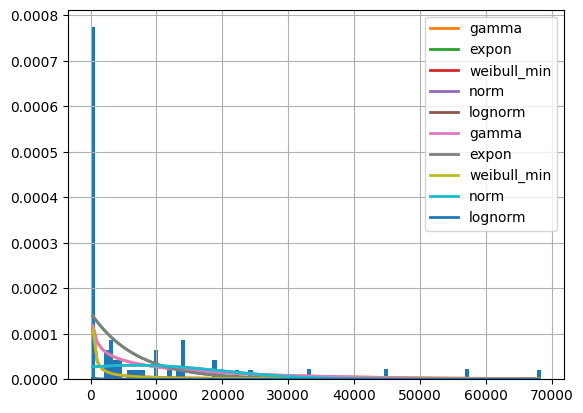

In [28]:
f = Fitter(claims, distributions=['norm', 'lognorm', 'expon', 'gamma', 'weibull_min'])
f.fit()
f.summary()
f.plot_pdf()

Best fit: {'gamma': {'a': 0.6840393909433906, 'loc': -3.4428309402426236e-26, 'scale': 24175.87954362238}}


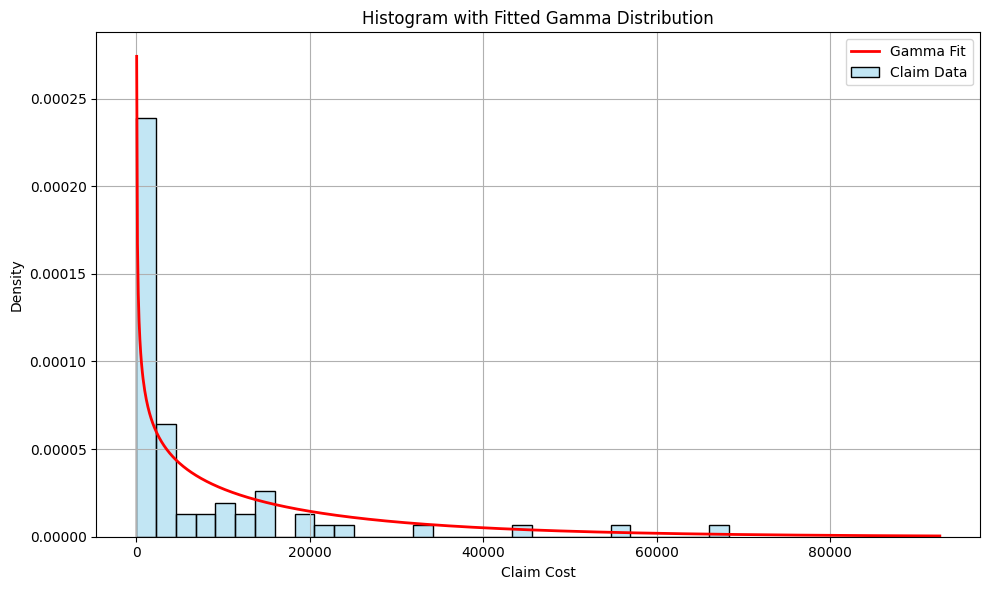

In [29]:
# Extract best-fitting distribution
best = f.get_best(method='sumsquare_error')
print("Best fit:", best)

# If the best fit is gamma, unpack its parameters
if 'gamma' in best:
    params = best['gamma']
    dist = stats.gamma(a=params['a'], loc=params['loc'], scale=params['scale'])

    # Generate x values from 1st to 99th percentile of the fitted gamma
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)
    pdf = dist.pdf(x)

    # Plot histogram of data + fitted gamma PDF
    plt.figure(figsize=(10, 6))
    sns.histplot(claims, bins=30, stat="density", color='skyblue', alpha=0.5, label='Claim Data')
    plt.plot(x, pdf, 'r-', lw=2, label='Gamma Fit')
    plt.title('Histogram with Fitted Gamma Distribution')
    plt.xlabel('Claim Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [31]:
# Here we will clean the data by removing zero claims and separating them from non-zero claims
zero_claims = claims[claims == 0]
non_zero_claims = claims[claims > 0]  # Gamma requires strictly positive values
number_of_claims = len(claims)
print(len(claims), len(non_zero_claims), len(zero_claims))

68 34 34


## Fitting a Gamma Distribution to Positive Claim Amounts

To model the distribution of claim severity, we fit a **Gamma distribution** to the subset of claims with **positive payout values**.

We exclude zero-valued claims because the Gamma distribution is only defined for strictly positive data.

The fitting is performed using **maximum likelihood estimation (MLE)** via `scipy.stats.gamma.fit`, with the location parameter (`loc`) constrained to 0. This constraint reflects the fact that claims cannot be negative and should not be shifted left of zero.

The result provides:
- $ \alpha $ (shape parameter): Governs the skewness
- $ \theta $ (scale parameter): Governs the spread

The fitted parameters are stored and used for simulating claim sizes in the loss model.


In [32]:
params_fit = gamma_dist.fit(non_zero_claims, floc=0)
params = {
    'a': params_fit[0],
    'loc': params_fit[1],
    'scale': params_fit[2]
}
params

{'a': 0.9757410727978164, 'loc': 0, 'scale': 13971.20929600291}

# Modeling Claim Frequency and Severity

From the dataset:
- **68 reported claims**
- **34 with positive payouts**, **34 with zero payout**
- **190 total policyholders**

This gives an **empirical claim frequency** of:

$
\hat{p}_c = \frac{68}{190} \approx 35.8\%
$

---

We model the **number of claims** in a portfolio of \( n = 100 \) policies using a **Poisson distribution**:

$
\lambda = n \cdot \hat{p}_c = 100 \cdot \frac{68}{190} \approx 35.8
$

$
N \sim \text{Poisson}(\lambda)
$

---

# Modeling Severity: Zero-Adjusted Gamma

Among the 68 observed claims:
- **50%** resulted in a **payout of 0**
- The remaining 50% followed a **Gamma-distributed severity**

We model this using a **zero-adjusted (hurdle) distribution**:

$
S =
\begin{cases}
0 & \text{with probability } p_0 = \frac{34}{68} = 0.5 \\
X \sim \text{Gamma}(\alpha, \theta) & \text{with probability } 1 - p_0 = 0.5
\end{cases}
$

---

# Total Portfolio Loss

For each simulation, we compute the aggregate loss:

$
L = \sum_{i=1}^{N} S_i
$

Where:
- $ N \sim \text{Poisson}(\lambda) $
- $ S_i \sim \text{Zero-Adjusted Gamma} $

---

We simulate $ L $ across **100,000 scenarios** to approximate the distribution of total portfolio losses and estimate tail risk metrics such as **VaR**, **CVaR**, and the **risk-adjusted premium**.


In [25]:
n_policies = 100
claim_freq = 68 / 190  # ~35.8%
p_zero = 34 / 68       # 50% of reported claims had zero payout
lambda_poisson = n_policies * claim_freq

n_simulations = 100000
total_losses = []

np.random.seed(42)

for _ in range(n_simulations):
    n_claims = poisson.rvs(lambda_poisson)
    if n_claims == 0:
        total_losses.append(0)
    else:
        # Zero-adjusted gamma: half of claims are zero, rest follow gamma
        payouts = []
        for _ in range(n_claims):
            if np.random.rand() < p_zero:
                payouts.append(0)
            else:
                payouts.append(gamma_dist.rvs(params['a'], loc=0, scale=params['scale']))
        total_losses.append(np.sum(payouts))

total_losses = np.array(total_losses)


## Risk Metrics and Distribution of Simulated Portfolio Losses

Using 100,000 simulated portfolio outcomes under the Poisson-Gamma model, we calculate key risk indicators to assess the potential financial exposure of the insurance portfolio:

- **Expected Total Loss**: The average portfolio loss across all scenarios, reflecting the central tendency of the risk.
- **Value at Risk (VaR)** at various confidence levels (e.g., 75% and 95%): The portfolio loss that is not exceeded in x% of the worst outcomes — providing a threshold for extreme loss events.
- **Conditional Value at Risk (CVaR)**: The average loss beyond each VaR threshold, offering a more comprehensive measure of tail severity than VaR alone.
- **Premium (CVaR 95 + 20%)**: A conservative pricing benchmark based on tail risk, with a 20% markup to account for capital costs, uncertainty, and profit.

The distribution is visually benchmarked against a normal approximation with the same mean and standard deviation to highlight the skewness and heavy tail behavior of actual losses.

In the plot:
- Histogram: Simulated distribution of total portfolio losses
- Dashed black line: Normal approximation
- Green line: Expected loss
- Colored dashed lines: VaR at various confidence levels (75%, 95%)
- Colored dotted lines: Corresponding CVaR thresholds


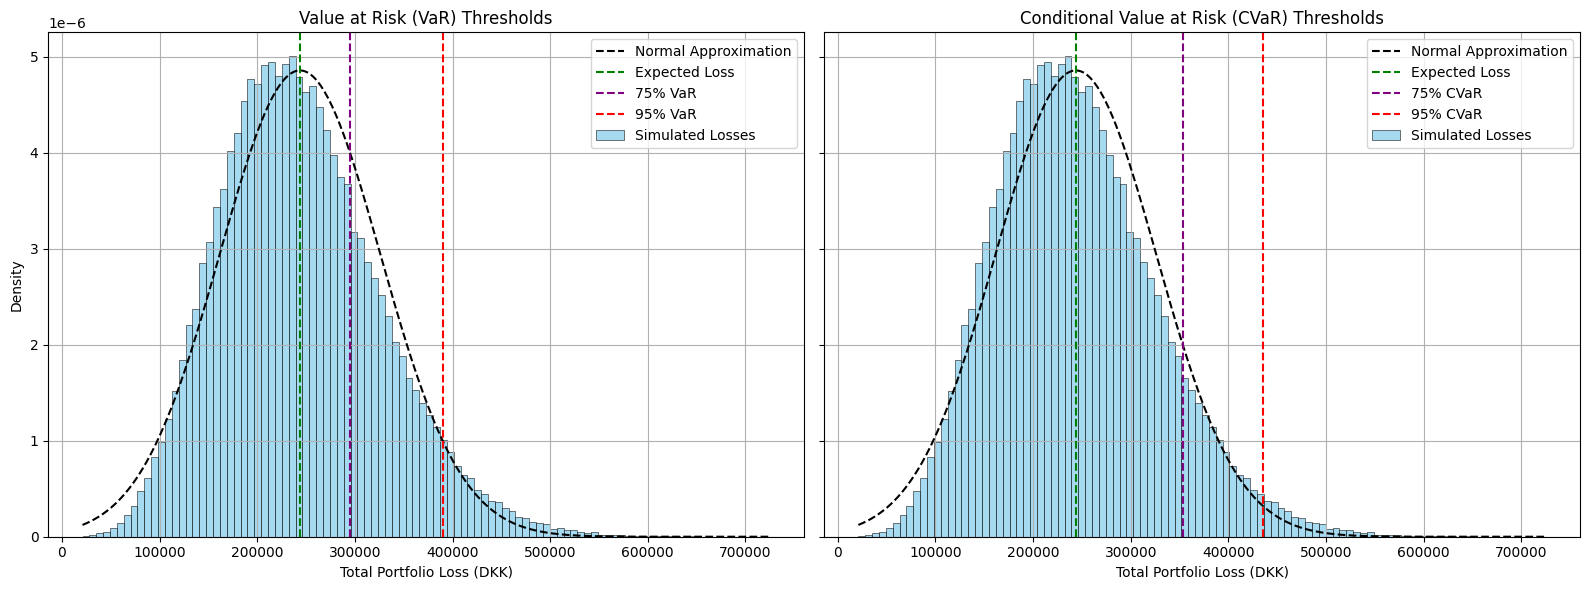

In [26]:
# === Compute risk metrics ===
expected_total_loss = np.mean(total_losses)
var_levels = [0.75, 0.95]
VaRs = {f"VaR_{int(v * 100)}": np.quantile(total_losses, v) for v in var_levels}
CVaRs = {f"CVaR_{int(v * 100)}": total_losses[total_losses >= VaRs[f"VaR_{int(v * 100)}"]].mean()
         for v in var_levels}
premium_cvar_markup = CVaRs["CVaR_95"] * 1.20

# === Plot: side-by-side VaR and CVaR ===
x = np.linspace(min(total_losses), max(total_losses), 1000)
normal_pdf = norm.pdf(x, loc=expected_total_loss, scale=np.std(total_losses))
colors = ['purple', 'red']

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- VaR plot ---
sns.histplot(total_losses, bins=100, stat='density', color='skyblue', ax=axs[0], label='Simulated Losses')
axs[0].plot(x, normal_pdf, 'k--', label='Normal Approximation')
axs[0].axvline(expected_total_loss, color='green', linestyle='--', label='Expected Loss')
for i, level in enumerate(var_levels):
    key = int(level * 100)
    axs[0].axvline(VaRs[f"VaR_{key}"], color=colors[i], linestyle='--', label=f'{key}% VaR')

axs[0].set_title('Value at Risk (VaR) Thresholds')
axs[0].set_xlabel('Total Portfolio Loss (DKK)')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)

# --- CVaR plot ---
sns.histplot(total_losses, bins=100, stat='density', color='skyblue', ax=axs[1], label='Simulated Losses')
axs[1].plot(x, normal_pdf, 'k--', label='Normal Approximation')
axs[1].axvline(expected_total_loss, color='green', linestyle='--', label='Expected Loss')
for i, level in enumerate(var_levels):
    key = int(level * 100)
    axs[1].axvline(CVaRs[f"CVaR_{key}"], color=colors[i], linestyle='--', label=f'{key}% CVaR')

axs[1].set_title('Conditional Value at Risk (CVaR) Thresholds')
axs[1].set_xlabel('Total Portfolio Loss (DKK)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Interpretation of Risk & Pricing Table

This summary presents the key risk metrics derived from a Poisson-Gamma model that captures both the frequency of claims and the distribution of their severities.

- **Expected Total Loss** represents the average simulated portfolio loss across 100,000 scenarios.
- **75% and 95% VaR (Value at Risk)** indicate the portfolio loss thresholds that are only exceeded in 25% and 5% of worst-case outcomes, respectively.
- **75% and 95% CVaR (Conditional VaR)** provide the **average loss** in the worst 25% and 5% of cases — offering a more accurate view of tail severity than VaR alone.
- **Total Premium (CVaR 95 + 20%)** incorporates a 20% markup on the 95% CVaR, accounting for capital loading, uncertainty, and profit margin.

This simulation supports pricing decisions across a realistic spectrum:
- A **baseline premium** aligned with expected loss per policy
- A **conservative premium** based on tail risk (CVaR 95) plus a safety margin

This dual-view approach helps balance competitive pricing with financial resilience.


In [27]:
# Ensure all needed keys are correctly created in VaRs and CVaRs
var_levels = [0.75, 0.95]
VaRs = {}
CVaRs = {}

for v in var_levels:
    key = str(int(v * 100))
    VaRs[key] = np.quantile(total_losses, v)
    CVaRs[key] = total_losses[total_losses >= VaRs[key]].mean()

# Recalculate premium per policy
premium_per_policy = premium_cvar_markup / 100
expected_per_policy = expected_total_loss / 100

# Updated Markdown summary
summary_md = f"""
## Summary of Risk & Pricing

| Metric                             | Value (DKK)         |
|------------------------------------|---------------------|
| Expected Total Loss                | {expected_total_loss:,.2f} |
| 75% Value at Risk (VaR)            | {VaRs['75']:,.2f} |
| 75% Conditional VaR (CVaR)         | {CVaRs['75']:,.2f} |
| 95% Value at Risk (VaR)            | {VaRs['95']:,.2f} |
| 95% Conditional VaR (CVaR)         | {CVaRs['95']:,.2f} |
| Total Premium (CVaR 95 + 20%)      | {CVaRs['95'] * 1.20:,.2f} |

This Poisson-Gamma simulation realistically captures both claim frequency and tail severity.

It supports a fair premium range of approximately:
- **{expected_per_policy:,.2f} DKK** per policy (based on expected loss) to **{premium_per_policy:,.2f} DKK** per policy (based on 95% CVaR + 20% margin)
"""

display(Markdown(summary_md))


## Summary of Risk & Pricing

| Metric                             | Value (DKK)         |
|------------------------------------|---------------------|
| Expected Total Loss                | 243,834.46 |
| 75% Value at Risk (VaR)            | 294,645.88 |
| 75% Conditional VaR (CVaR)         | 353,641.35 |
| 95% Value at Risk (VaR)            | 389,964.72 |
| 95% Conditional VaR (CVaR)         | 435,889.03 |
| Total Premium (CVaR 95 + 20%)      | 523,066.83 |

This Poisson-Gamma simulation realistically captures both claim frequency and tail severity.

It supports a fair premium range of approximately:
- **2,438.34 DKK** per policy (based on expected loss) to **5,230.67 DKK** per policy (based on 95% CVaR + 20% margin)


2025-05-21 23:14:34.336 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)
2025-05-21 23:14:34.338 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.0)
2025-05-21 23:14:34.340 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)
2025-05-21 23:14:34.371 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.0)
2025-05-21 23:14:34.373 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted weibull_min distribution with error=0.0)


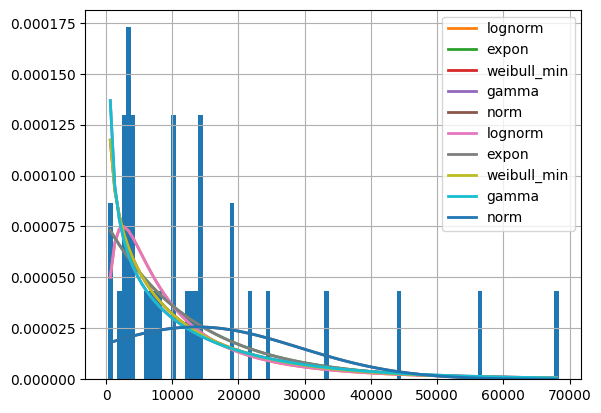

In [33]:
f = Fitter(non_zero_claims, distributions=['norm', 'lognorm', 'expon', 'gamma', 'weibull_min'])
f.fit()
f.summary()
f.plot_pdf()

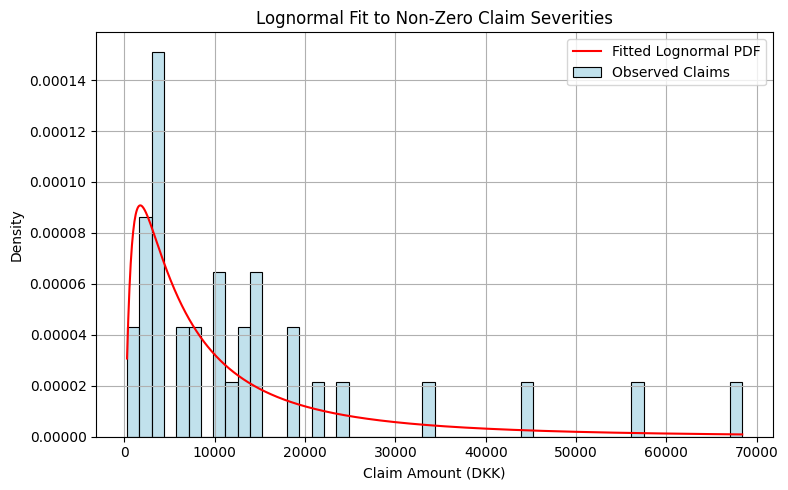

In [38]:
p_zero = 1 - len(non_zero_claims) / len(claims)

# Fit lognormal distribution to non-zero claims
shape, loc, scale = lognorm.fit(non_zero_claims, floc=0)
x = np.linspace(non_zero_claims.min(), non_zero_claims.max(), 1000)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)
lognorm_params = {"shape": shape, "loc": loc, "scale": scale}

# Plot histogram and fitted PDF
plt.figure(figsize=(8, 5))
sns.histplot(non_zero_claims, bins=50, stat='density', color='lightblue', label='Observed Claims')
plt.plot(x, pdf, 'r-', label='Fitted Lognormal PDF')
plt.title('Lognormal Fit to Non-Zero Claim Severities')
plt.xlabel('Claim Amount (DKK)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# === Simulate portfolio losses ===
n_policies = 100
claim_freq = len(claims) / 190
lambda_poisson = n_policies * claim_freq
n_simulations = 100000
np.random.seed(42)

total_losses = []
for _ in range(n_simulations):
    n_claims = poisson.rvs(lambda_poisson)
    payouts = []
    for _ in range(n_claims):
        if np.random.rand() < p_zero:
            payouts.append(0)
        else:
            payouts.append(lognorm.rvs(lognorm_params["shape"], loc=0, scale=lognorm_params["scale"]))
    total_losses.append(np.sum(payouts))

total_losses = np.array(total_losses)

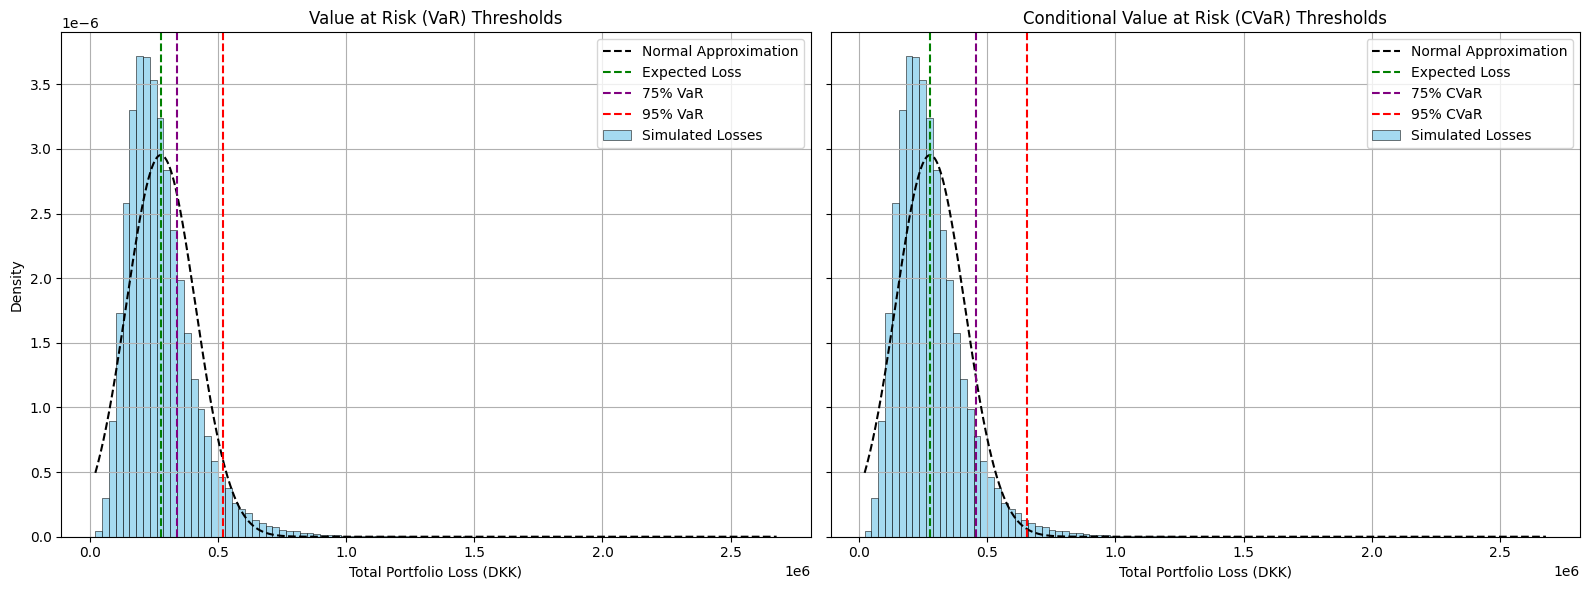

In [43]:
# === Compute risk metrics ===
expected_total_loss = np.mean(total_losses)
var_levels = [0.75, 0.95]
VaRs = {f"VaR_{int(v * 100)}": np.quantile(total_losses, v) for v in var_levels}
CVaRs = {f"CVaR_{int(v * 100)}": total_losses[total_losses >= VaRs[f"VaR_{int(v * 100)}"]].mean()
         for v in var_levels}
premium_cvar_markup = CVaRs["CVaR_95"] * 1.20
expected_per_policy = expected_total_loss / 100
premium_per_policy = premium_cvar_markup / 100

# === Plot: side-by-side VaR and CVaR ===
x = np.linspace(min(total_losses), max(total_losses), 1000)
normal_pdf = norm.pdf(x, loc=expected_total_loss, scale=np.std(total_losses))
colors = ['purple', 'red']

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- VaR plot ---
sns.histplot(total_losses, bins=100, stat='density', color='skyblue', ax=axs[0], label='Simulated Losses')
axs[0].plot(x, normal_pdf, 'k--', label='Normal Approximation')
axs[0].axvline(expected_total_loss, color='green', linestyle='--', label='Expected Loss')
for i, level in enumerate(var_levels):
    key = int(level * 100)
    axs[0].axvline(VaRs[f"VaR_{key}"], color=colors[i], linestyle='--', label=f'{key}% VaR')

axs[0].set_title('Value at Risk (VaR) Thresholds')
axs[0].set_xlabel('Total Portfolio Loss (DKK)')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)

# --- CVaR plot ---
sns.histplot(total_losses, bins=100, stat='density', color='skyblue', ax=axs[1], label='Simulated Losses')
axs[1].plot(x, normal_pdf, 'k--', label='Normal Approximation')
axs[1].axvline(expected_total_loss, color='green', linestyle='--', label='Expected Loss')
for i, level in enumerate(var_levels):
    key = int(level * 100)
    axs[1].axvline(CVaRs[f"CVaR_{key}"], color=colors[i], linestyle='--', label=f'{key}% CVaR')

axs[1].set_title('Conditional Value at Risk (CVaR) Thresholds')
axs[1].set_xlabel('Total Portfolio Loss (DKK)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [44]:
# === Markdown summary ===
summary_md = f"""
## 📊 Summary of Risk & Pricing – Lognormal Severity

| Metric                             | Value (DKK)         |
|------------------------------------|---------------------|
| Expected Total Loss                | {expected_total_loss:,.2f} |
| 95% Value at Risk (VaR)            | {VaR_95:,.2f} |
| 95% Conditional VaR (CVaR)         | {CVaR_95:,.2f} |
| Total Premium (CVaR 95 + 20%)      | {premium_cvar_markup:,.2f} |

This simulation uses a Poisson process for claim count and a Lognormal distribution for non-zero severities.

Estimated premium range:
- **{expected_per_policy:,.2f} DKK** per policy (expected loss)
- **{premium_per_policy:,.2f} DKK** per policy (95% CVaR + 20% margin)
"""

display(Markdown(summary_md))


## 📊 Summary of Risk & Pricing – Lognormal Severity

| Metric                             | Value (DKK)         |
|------------------------------------|---------------------|
| Expected Total Loss                | 277,637.13 |
| 95% Value at Risk (VaR)            | 520,779.51 |
| 95% Conditional VaR (CVaR)         | 653,635.44 |
| Total Premium (CVaR 95 + 20%)      | 784,362.53 |

This simulation uses a Poisson process for claim count and a Lognormal distribution for non-zero severities.

Estimated premium range:
- **2,776.37 DKK** per policy (expected loss)
- **7,843.63 DKK** per policy (95% CVaR + 20% margin)
